Notebook for testing nn performance

In [1]:
# import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from data_preprocessing import extract_csv_info, format_data, shuffle_and_split, split_input_output
from neural import train_and_generate_feedforward_network, train_and_generate_recurrent_network, train_and_generate_preisach_network, train_and_generate_recurrent_preisach_network

[(0.0, 0.0), (0.0161, 7.46e-05), (0.0709, 0.000329), (0.125582, 0.000584), (0.180231, 0.000838), (0.234808, 0.00109), (0.289311, 0.00135), (0.343741, 0.0016), (0.398099, 0.00186), (0.452384, 0.00211), (0.506597, 0.00237), (0.58932, 0.00275), (0.740654, 0.00347), (0.891427, 0.00418), (1.041643, 0.0049), (1.191305, 0.00561), (1.340418, 0.00632), (1.488984, 0.00704), (1.637007, 0.00775), (1.784492, 0.00847), (1.931441, 0.00918), (2.096868, 0.00999), (2.307293, 0.011), (2.516628, 0.012), (2.724883, 0.0131), (2.932067, 0.0141), (3.138192, 0.0151), (3.343266, 0.0162), (3.5473, 0.0172), (3.750304, 0.0182), (3.952287, 0.0193), (4.159156, 0.0203), (4.379123, 0.0215), (4.59789, 0.0226), (4.815468, 0.0237), (5.031871, 0.0249), (5.24711, 0.026), (5.461198, 0.0271), (5.674144, 0.0283), (5.885962, 0.0294), (6.096663, 0.0305), (6.24499, 0.0316), (6.320205, 0.0326), (6.395337, 0.0336), (6.470317, 0.0346), (6.545148, 0.0356), (6.619829, 0.0366), (6.694361, 0.0375), (6.768747, 0.0385), (6.842986, 0.0395

In [3]:
# Function to compute MSE of predicted values
def compute_mse(actual_y, predicted_y):
    actual_y = np.asarray(actual_y)
    predicted_y = np.asarray(predicted_y)
    diff = np.subtract(actual_y, predicted_y)
    squared = np.square(diff)
    mse = np.mean(squared)
    return mse


# test compute mse
# y = [11, 20, 19, 17, 10]
# y_pred = [12, 18, 19.5, 18, 9]
# print(compute_mse(y, y_pred))

In [4]:
# Function for plotting predicted values from NN
# TODO: add figsize and xlim as input to function to allow customization
def plot_predicted(next_h, next_b, model_name):
    plt.figure(figsize=(20, 12))
    plt.xlim(-750, 750)
    plt.plot(next_h, next_b, marker="o", color='black')
    plt.title(model_name + " Output Plot")
    plt.xlabel("Magnetic Field H (T)")
    plt.ylabel("Magnetic Flux B (A/m)")
    plt.show()

## Data Loading and Preprocessing

In [3]:
# Load data for training
raw_train_data = extract_csv_info("./data_simulated/M19_29Gauge - Sheet1.csv")
# format into (current H, current B, next H, next B)
formatted_data = format_data(raw_train_data)
#train, test = shuffle_and_split(formatted_data)
train_x, train_y = split_input_output(formatted_data)
#test_x, test_y = split_input_output(test)


In [6]:
# Load data for testing
raw_test_data = extract_csv_info("./data_simulated/M19_TESTINGDATA - M19_TESTINGDATA.csv")
formatted_test_data = format_data(raw_test_data)
test_x, test_y = split_input_output(formatted_test_data)

# Separate next_h values into separate list for plotting output
test_next_h = list()
for i in range(len(test_x)):
    test_next_h.append(test_x[i][2])


## Feedforward Network

In [7]:
# Generate and train feedforward network
feedforward_model = train_and_generate_feedforward_network(train_x, train_y, "feedforward.model", n_epochs=20)

Epoch 1/20
63/63 [==============================] - 1s 3ms/step - loss: 0.1140 - mean_squared_error: 0.1140
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 4/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 5/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 7/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 8/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 9/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 10/20
63/63 [=========

In [8]:
# Load feedforward model
feedforward_model = tf.keras.models.load_model("./models/feedforward.model")

In [9]:
# Evaluate feedforward network
feedforward_prediction = feedforward_model.predict(test_x)
mse = compute_mse(test_y, feedforward_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
feedforward_model.evaluate(test_x, test_y)

37/37 [==============================] - 0s 1ms/step
MSE: 0.8379484511724411
37/37 [==============================] - 0s 2ms/step - loss: 0.0361 - mean_squared_error: 0.0361


[0.036127034574747086, 0.036127034574747086]

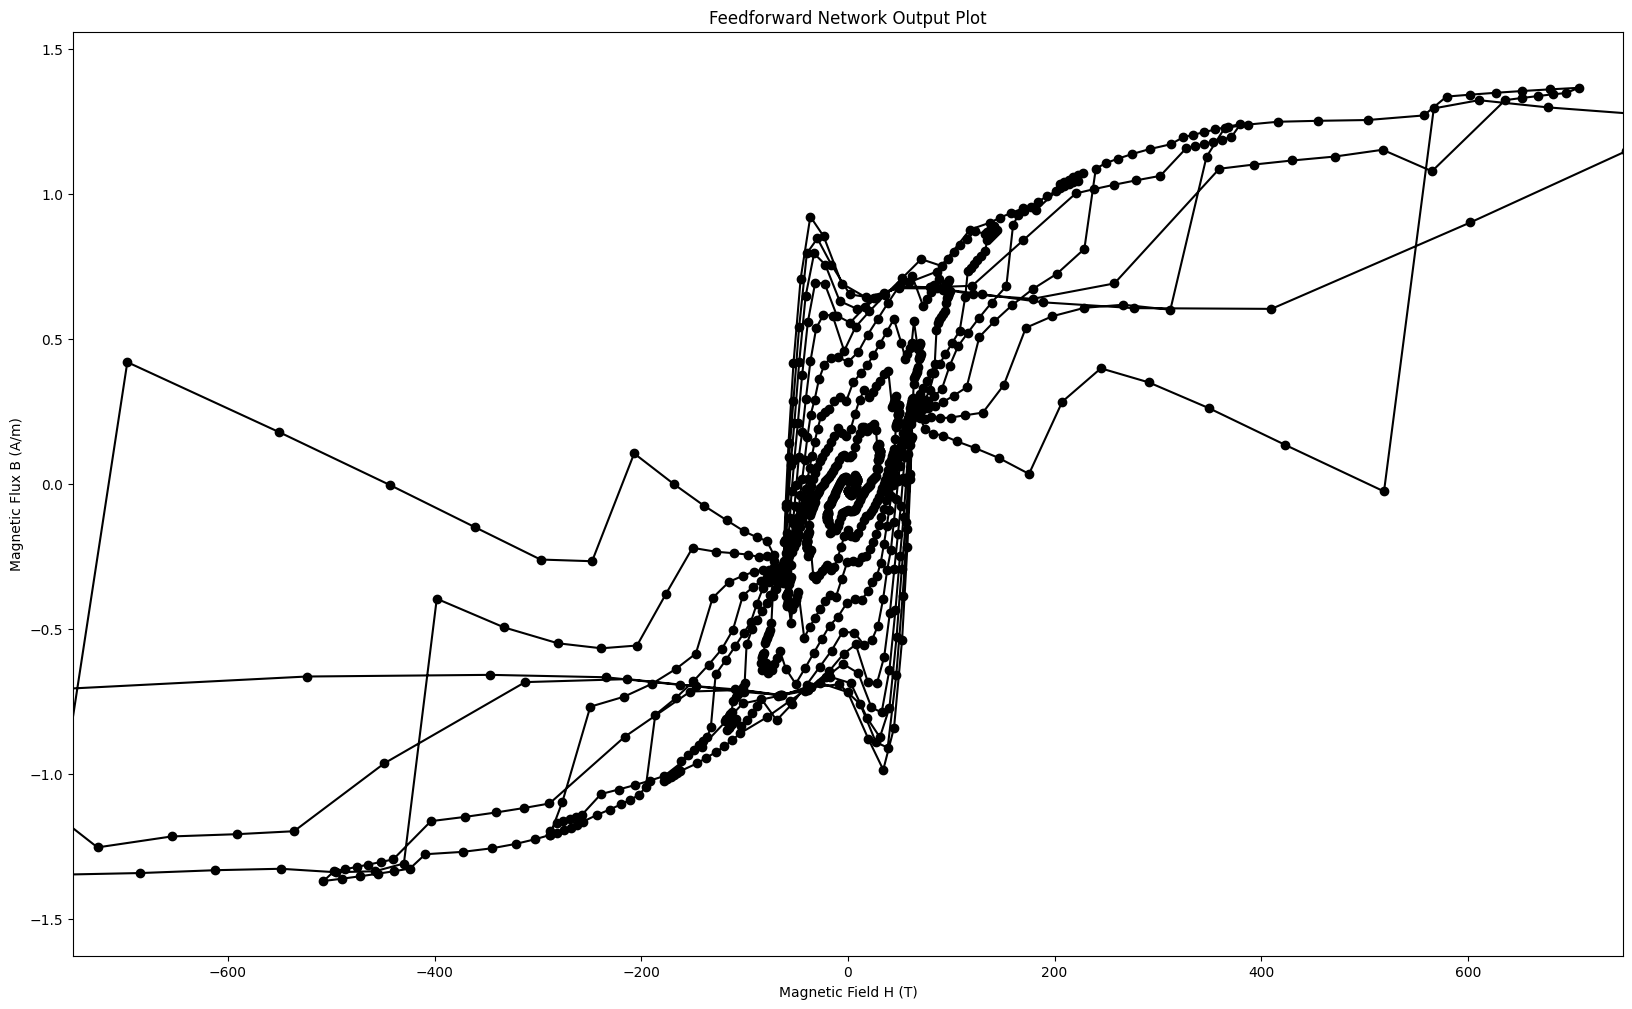

In [10]:
# Plot feedforward output
plot_predicted(test_next_h, feedforward_prediction, "Feedforward Network")


## Preisach Network

In [11]:
# Generate and train preisach network
pnn_model = train_and_generate_preisach_network(train_x, train_y, "preisach.model", n_epochs=20)

Epoch 1/20
63/63 [==============================] - 1s 4ms/step - loss: 0.1173 - mean_squared_error: 0.1173
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0425 - mean_squared_error: 0.0425
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0404 - mean_squared_error: 0.0404
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0425 - mean_squared_error: 0.0425
Epoch 8/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 9/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0386 - mean_squared_error: 0.0386
Epoch 10/20
63/63 [=========

In [12]:
# Load preisach model
pnn_model = tf.keras.models.load_model("./models/preisach.model")

In [13]:
#Evaluate preisach model
pnn_prediction = pnn_model.predict(test_x)
mse = compute_mse(test_y, pnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
pnn_model.evaluate(test_x, test_y)



37/37 [==============================] - 0s 1ms/step
MSE: 0.8115219420528362
37/37 [==============================] - 0s 2ms/step - loss: 0.0554 - mean_squared_error: 0.0554


[0.05542262643575668, 0.05542262643575668]

## Recurrent Network
no stop activation layer

In [ ]:
# Generate and train recurrent network (no stop operator)
rnn_model = train_and_generate_recurrent_network(train_x, train_y, "recurrent.model", n_epochs=20)

Epoch 1/20


In [ ]:
# Load recurrent network
rnn_model = tf.keras.models.load_model("./models/recurrent.model")

In [ ]:
# Evaluate recurrent model
rnn_prediction = rnn_model.predict(test_x)
mse = compute_mse(test_y, rnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
rnn_model.evaluate(test_x, test_y)



## Recurrent Preisach Network
includes stop activation layer

In [ ]:
# Generate and train recurrent preisach network
# TODO
